In [21]:
from numcosmo_py import Ncm, Nc

Ncm.cfg_init()
# Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())
import numpy as np
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
from scipy.special import erf
import sys
sys.path.insert(0, "/global/homes/l/lettieri/NumCosmo/notebooks/richness_proxy/Scripts")
from bdata import DataB
from model_fitting import ModelFitting
import pandas as pd
from getdist import plots
from getdist.mcsamples import  MCSamples
import getdist


In [2]:
cluster_m = Nc.ClusterMassLnrichExt(lnRichness_min=0, lnRichness_max=6)
cluster_m.param_set_by_name("cut", np.log(5.0))

cosmo = Nc.HICosmoDEXcdm()
cosmo.omega_x2omega_k()
cosmo.param_set_by_name("H0", 67.74)
cosmo.param_set_by_name("Omegab", 0.0486)
cosmo.param_set_by_name("Omegac", 0.3089 - 0.0486)  # 0.2603
cosmo.param_set_by_name("Omegak", 0.00)
cosmo.param_set_by_name("w", -1.0)  # -1.0

prim = Nc.HIPrimPowerLaw.new()
prim.param_set_by_name("ln10e10ASA", 3.0116707481421923)
prim.param_set_by_name("n_SA", 0.9667)


reion = Nc.HIReionCamb.new()

cosmo.add_submodel(prim)
cosmo.add_submodel(reion)

table_redmapper_halos = fits.open("../forecast/DC2/catalogs/redmapper_halos.fits")[
    1
].data
table_redmapper_halos = Table(table_redmapper_halos)

clusters_dt = Table(
    [
        table_redmapper_halos["log10M"] * np.log(10),
        table_redmapper_halos["R"],
        table_redmapper_halos["z"],
    ],
    names=("Mvir", "richness", "z"),
)
mset = Ncm.MSet.new_array([cluster_m, cosmo])
mset.prepare_fparam_map()


lnM_v = Ncm.Vector.new(len(clusters_dt))
z_v = Ncm.Vector.new(len(clusters_dt))
rich_v = Ncm.Vector.new(len(clusters_dt))

for i, mass in enumerate(clusters_dt["Mvir"]):
    lnM_v.set(i, mass)

for i, z in enumerate(clusters_dt["z"]):
    z_v.set(i, z)

for i, rich in enumerate(clusters_dt["richness"]):
    rich_v.set(i, np.log(rich))
print(len(table_redmapper_halos["z"]))
dmr = Nc.DataClusterMassRich.new()
dmr_resampled_extended = Nc.DataClusterMassRich.new()
dmr_resampled_extended_nocut = Nc.DataClusterMassRich.new()

dmr.set_data(lnM_v, z_v, rich_v)
dmr_resampled_extended.set_data(lnM_v, z_v, rich_v)
dmr_resampled_extended_nocut.set_data(lnM_v, z_v, rich_v)

27581


In [3]:
mset = Ncm.MSet()
mset.set(cluster_m)
dmr_resampled_extended.m2lnL_val(mset)
mset.param_set_all_ftype(Ncm.ParamType.FREE)  # All parameters free
fixed_parameters = ["A0", "cut", "cutM1", "cutZ1"]

for par in fixed_parameters:
    mset["NcClusterMass"].param_set_desc(par, {"fit": False})

# Data
dset = Ncm.Dataset.new()
dset.append_data(dmr)

# Likelihood
lh = Ncm.Likelihood.new(dset)

experiment = Ncm.ObjDictStr()
experiment.set("likelihood", lh)
experiment.set("model-set", mset)
ser = Ncm.Serialize.new(Ncm.SerializeOpt.CLEAN_DUP)
ser.dict_str_to_yaml_file(experiment, "resample_test.yaml")

# Fit
fit = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL
)
fit.log_info()
fit.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
fit.log_info()

nwalkers = 1500

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)

apes = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new(fit, nwalkers, init_sampler, apes, Ncm.FitRunMsgs.FULL)
esmcmc.set_nthreads(2)
esmcmc.set_data_file("resample_mcmc_extended.fits")

esmcmc.start_run()
esmcmc.run(400)
esmcmc.end_run()

esmcmc.mean_covar()
fit.log_covar()


#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  3.19                [FREE]
#   -    muM1[01]:  0.868588963806504   [FREE]
#   -    muZ1[02]: -0.304006137332276   [FREE]
#   -    muM2[03]:  0                   [FREE]
#   -    muZ2[04]:  0                   [FREE]
#   -    muMZ[05]:  0                   [FREE]
#   -  sigma0[06]:  0.33                [FREE]
#   - sigmaM1[07]: -0.0347435585522601  [FREE]
#   - sigmaZ1[08]:  0                   [FREE]
#   - sigmaM2[09]:  0                   [FREE]
#   - sigmaZ2[10]:  0                   [FREE]
#   - sigmaMZ[11]:  0                   [FREE]
#   -      A0[12]:  0                   [FIX

In [4]:
cluster_m = Nc.ClusterMassLnrichExt(lnRichness_min=np.log(1.0), lnRichness_max=6)
cluster_m.param_set_by_name("cut", np.log(5.0))

cluster_m.param_set_by_name("mu",  4.0038598058062)
cluster_m.param_set_by_name("muM1",  0.762972345921432 )
cluster_m.param_set_by_name("muZ1",0.708756626883261)
cluster_m.param_set_by_name("muM2", -0.121527448120085)
cluster_m.param_set_by_name("muZ2", -1.67338018589322  )
cluster_m.param_set_by_name("muMZ", 0.300433877149989 )
cluster_m.param_set_by_name("sigma0",0.686143422714232 )
cluster_m.param_set_by_name("sigmaM1", 0.256365977954059)
cluster_m.param_set_by_name("sigmaZ1", 0.0474611826960911)
cluster_m.param_set_by_name("sigmaM2", 0.0859756561023792)
cluster_m.param_set_by_name("sigmaZ2", 0.0442358416209473)
cluster_m.param_set_by_name("sigmaMZ",0.0126032205223553)

mset2 = Ncm.MSet.new_array([cluster_m, cosmo])
mset2.prepare_fparam_map()

rng = Ncm.RNG.seeded_new(None, 1312)
dmr_resampled_extended.resample(mset2, rng)

cluster_m.param_set_by_name("cut", np.log(1.0))
dmr_resampled_extended_nocut.resample(mset2, rng)

cluster_m.param_set_by_name("cut", np.log(5.0))
mset = Ncm.MSet()
mset.set(cluster_m)
dmr_resampled_extended.m2lnL_val(mset)
mset.param_set_all_ftype(Ncm.ParamType.FREE)  # All parameters free
fixed_parameters = ["A0", "cut", "cutM1", "cutZ1"]

for par in fixed_parameters:
    mset["NcClusterMass"].param_set_desc(par, {"fit": False})

# Data
dset = Ncm.Dataset.new()
dset.append_data(dmr_resampled_extended)

# Likelihood
lh = Ncm.Likelihood.new(dset)

# Fit

fit = Ncm.Fit.factory( Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL )
fit.log_info()


Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)


fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(2)
fitmc.set_data_file("resample_mc_extended.fits")

fitmc.start_run()
fitmc.run(3000)
fitmc.end_run()
fitmc.mean_covar()
fit.log_covar()

mcat = Ncm.MSetCatalog.new_from_file_ro('resample_mc_extended.fits',0)
mcat.log_full_covar()

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  4.0038598058062     [FREE]
#   -    muM1[01]:  0.762972345921432   [FREE]
#   -    muZ1[02]:  0.708756626883261   [FREE]
#   -    muM2[03]: -0.121527448120085   [FREE]
#   -    muZ2[04]: -1.67338018589322    [FREE]
#   -    muMZ[05]:  0.300433877149989   [FREE]
#   -  sigma0[06]:  0.686143422714232   [FREE]
#   - sigmaM1[07]:  0.256365977954059   [FREE]
#   - sigmaZ1[08]:  0.0474611826960911  [FREE]
#   - sigmaM2[09]:  0.0859756561023792  [FREE]
#   - sigmaZ2[10]:  0.0442358416209473  [FREE]
#   - sigmaMZ[11]:  0.0126032205223553  [FREE]
#   -      A0[12]:  0                   [FIX

In [7]:
data_fit_full = pd.DataFrame(fits.open("resample_mc_extended.fits")[1].data).iloc[:, 0:2].T

data_fit_void = np.array(data_fit_full)
data_fit = []
for item in data_fit_void:
    arr= np.array(item)
    data_fit.append(np.asarray(arr.tolist()))

names = [
    '0',
    '1',
]
labels=[r"-2 \ln L" , r"\mu_0", r"\mu_{M1}", r"\mu_{M2}", r"\mu_{Z1}",r"\mu_{Z2}", r"\mu_{MZ}",
        r"\sigma_0", r"\sigma_{M1}", r"\sigma_{M2}", r"\sigma_{Z1}", r"\sigma_{Z2}", r"\sigma_{MZ}"]
settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 3,
    "smooth_scale_1D": 3,
    "boundary_correction_order": 0,
}
samples3 = MCSamples(samples=data_fit, names=names, labels=labels, settings=settings)

bf=[mcat.get_bestfit_row().dup_array()[i] for i, param in enumerate(names)]

    
samples3.removeBurn(0.3)

# Triangle plot
g2 = plots.get_subplot_plotter()
g2.triangle_plot(
    [samples3],
    filled=True,
    contour_ls="-",
    contour_lws=1,
    fine_bins=1,
    colors=['#b186f1'],
    fontsize=70,
    line_args=[{'lw':1.2,'ls':'-', 'color':'#b186f1'}],
        legend_labels=["Linear", ],
)

for i, param in enumerate(names):
    density = samples3.get1DDensity(param)
    x = density.x
    y = density.P
    lower1sigma = density.getLimits(0.68)[0]
    upper1sigma = density.getLimits(0.68)[1]
    lower2sigma = density.getLimits(0.95)[0]
    upper2sigma = density.getLimits(0.95)[1]
    g2.subplots[i , i].fill_between(
        x, y, where=((x >= lower1sigma) & (x <= upper1sigma)),
        color='blue', alpha=0.3, label='1σ' if i == 0 else ""
    )

    g2.subplots[i , i].fill_between(
        x, y, where=((x >= lower2sigma) & (x <= upper2sigma)),
        color='blue', alpha=0.1, label='2σ' if i == 0 else ""
    )

    
    

for i, param1 in enumerate(names):
    for j, param2 in enumerate(names):
        if i == j:
            g2.subplots[i, j].axvline(bf[i], color='red', linestyle='--', label='Best Fit')
        elif i > j:
           g2.subplots[i, j].axvline(bf[j], color='red', linestyle='--')
           g2.subplots[i, j].axhline(bf[i], color='red', linestyle='--')


plt.savefig('mc_extended_corner_plot.png')
plt.show()

Removed no burn in


In [17]:
lnM_data = np.array(dmr.props.lnM_cluster.dup_array())
z_data = np.array(dmr.props.z_cluster.dup_array())
lnR_data = np.array(dmr.props.lnR_cluster.dup_array())

lnM_resampled_extended = np.array(dmr_resampled_extended.props.lnM_cluster.dup_array())
z_resampled_extended = np.array(dmr_resampled_extended.props.z_cluster.dup_array())
lnR_resampled_extended = np.array(dmr_resampled_extended.props.lnR_cluster.dup_array())

lnM_resampled_extended_nocut = np.array(dmr_resampled_extended_nocut.props.lnM_cluster.dup_array())
z_resampled_extended_nocut = np.array(dmr_resampled_extended_nocut.props.z_cluster.dup_array())
lnR_resampled_extended_nocut = np.array(dmr_resampled_extended_nocut.props.lnR_cluster.dup_array())

lnM_test = lnM_resampled_extended != lnM_data
z_test = z_resampled_extended != z_data
lnR_test = lnR_resampled_extended == lnR_data

for i in range(len(lnM_data)):
    if lnM_test[i] or z_test[i] or lnR_test[i]:
        print("original:  lnM = %.5f , z = %.5f , lnR = %.5f" % (lnM_data[i], z_data[i], lnR_data[i]))
        print(
            "resampled: lnM = %.5f , z = %.5f , lnR = %.5f \n "
            % (lnM_resampled_extended[i], z_resampled_extended[i], lnR_resampled_extended[i])
        )

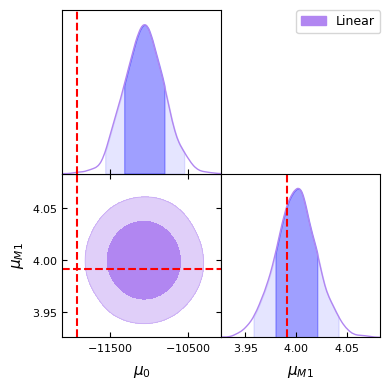

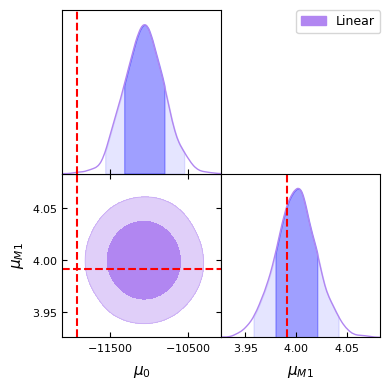

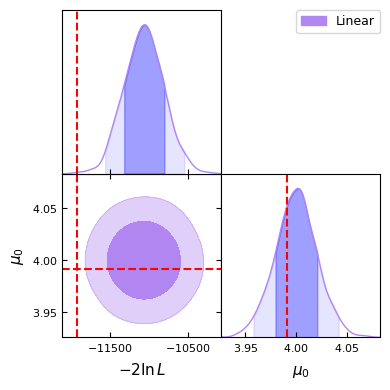

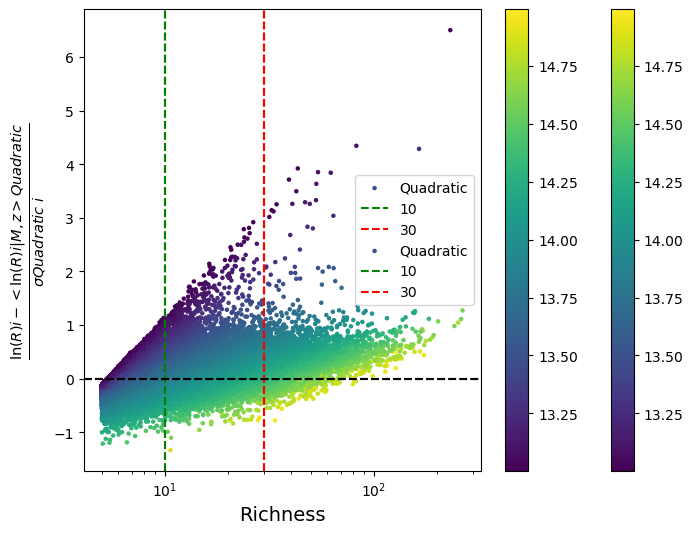

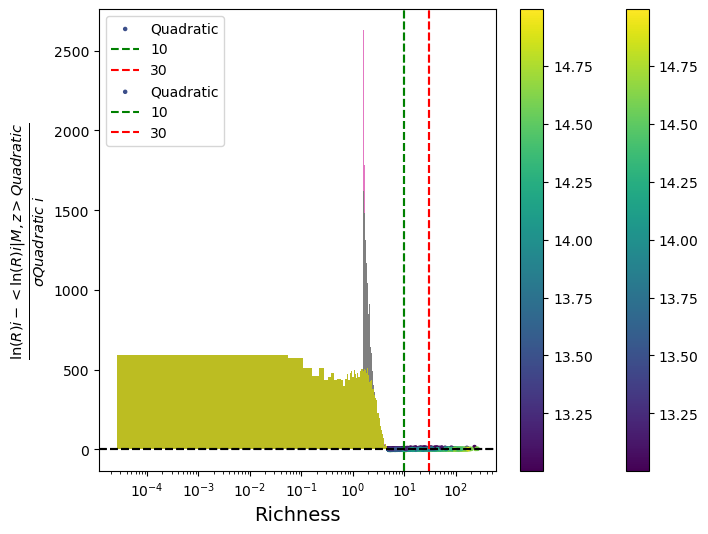

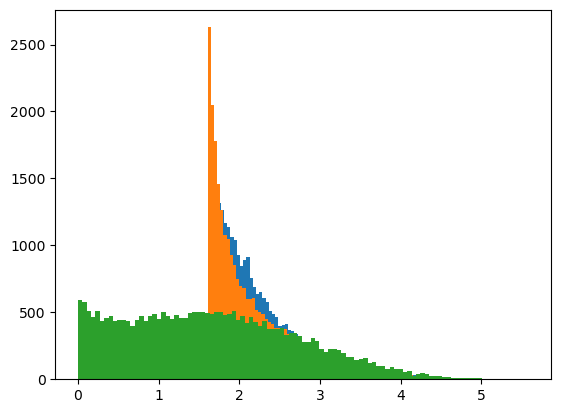

In [22]:
plt.hist(lnR_resampled_extended , bins=100)
plt.hist(lnR_data , bins=100)
plt.hist(lnR_resampled_extended_nocut , bins=100)
plt.show()

plt.hist(lnR_data , bins=100)
plt.hist(lnR_resampled_extended , bins=100)
plt.hist(lnR_resampled_extended_nocut , bins=100)
plt.show()

In [28]:
cluster_m = Nc.ClusterMassAscaso(lnRichness_min=0, lnRichness_max=6)
cluster_m.param_set_by_name("cut", np.log(5.0))

cosmo = Nc.HICosmoDEXcdm()
cosmo.omega_x2omega_k()
cosmo.param_set_by_name("H0", 67.74)
cosmo.param_set_by_name("Omegab", 0.0486)
cosmo.param_set_by_name("Omegac", 0.3089 - 0.0486)  # 0.2603
cosmo.param_set_by_name("Omegak", 0.00)
cosmo.param_set_by_name("w", -1.0)  # -1.0

prim = Nc.HIPrimPowerLaw.new()
prim.param_set_by_name("ln10e10ASA", 3.0116707481421923)
prim.param_set_by_name("n_SA", 0.9667)


reion = Nc.HIReionCamb.new()

cosmo.add_submodel(prim)
cosmo.add_submodel(reion)

table_redmapper_halos = fits.open("../forecast/DC2/catalogs/redmapper_halos.fits")[
    1
].data
table_redmapper_halos = Table(table_redmapper_halos)

clusters_dt = Table(
    [
        table_redmapper_halos["log10M"] * np.log(10),
        table_redmapper_halos["R"],
        table_redmapper_halos["z"],
    ],
    names=("Mvir", "richness", "z"),
)
mset = Ncm.MSet.new_array([cluster_m, cosmo])
mset.prepare_fparam_map()


lnM_v = Ncm.Vector.new(len(clusters_dt))
z_v = Ncm.Vector.new(len(clusters_dt))
rich_v = Ncm.Vector.new(len(clusters_dt))

for i, mass in enumerate(clusters_dt["Mvir"]):
    lnM_v.set(i, mass)

for i, z in enumerate(clusters_dt["z"]):
    z_v.set(i, z)

for i, rich in enumerate(clusters_dt["richness"]):
    rich_v.set(i, np.log(rich))

dmr = Nc.DataClusterMassRich.new()
dmr_resampled_ascaso = Nc.DataClusterMassRich.new()
dmr_resampled_ascaso_nocut = Nc.DataClusterMassRich.new()

dmr.set_data(lnM_v, z_v, rich_v)
dmr_resampled_ascaso.set_data(lnM_v, z_v, rich_v)
dmr_resampled_ascaso_nocut.set_data(lnM_v, z_v, rich_v)

In [29]:
mset = Ncm.MSet()
mset.set(cluster_m)
dmr_resampled_ascaso.m2lnL_val(mset)
mset.param_set_all_ftype(Ncm.ParamType.FREE)  # All parameters free
fixed_parameters = ["cut"]

for par in fixed_parameters:
    mset["NcClusterMass"].param_set_desc(par, {"fit": False})

# Data
dset = Ncm.Dataset.new()
dset.append_data(dmr)

# Likelihood
lh = Ncm.Likelihood.new(dset)

experiment = Ncm.ObjDictStr()
experiment.set("likelihood", lh)
experiment.set("model-set", mset)
ser = Ncm.Serialize.new(Ncm.SerializeOpt.CLEAN_DUP)
ser.dict_str_to_yaml_file(experiment, "resample_test_ascaso.yaml")

# Fit
fit = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL
)
fit.log_info()
fit.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
fit.log_info()

nwalkers = 1500

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)

apes = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new(fit, nwalkers, init_sampler, apes, Ncm.FitRunMsgs.FULL)
esmcmc.set_nthreads(2)
esmcmc.set_data_file("resample_mcmc_ascaso.fits")

esmcmc.start_run()
esmcmc.run(400)
esmcmc.end_run()

esmcmc.mean_covar()
fit.log_covar()


#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -    mup0[00]:  3.19                [FREE]
#   -    mup1[01]:  0.868588963806504   [FREE]
#   -    mup2[02]: -0.304006137332276   [FREE]
#   - sigmap0[03]:  0.33                [FREE]
#   - sigmap1[04]: -0.0347435585522601  [FREE]
#   - sigmap2[05]:  0                   [FREE]
#   -     cut[06]:  1.6094379124341     [FIXED]
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
.........................................................

In [30]:
cluster_m = Nc.ClusterMassAscaso(lnRichness_min=np.log(1.0), lnRichness_max=6)
cluster_m.param_set_by_name("cut", np.log(5.0))

cluster_m.param_set_by_name("mup0",   4.11945317984568 )
cluster_m.param_set_by_name("mup1", 1.11236863168254)
cluster_m.param_set_by_name("mup2",0.299464198653602)
cluster_m.param_set_by_name("sigmap0",0.471246505057074    )
cluster_m.param_set_by_name("sigmap1",-0.0591674971985774  )
cluster_m.param_set_by_name("sigmap2",-0.109077938873429)

mset2 = Ncm.MSet.new_array([cluster_m, cosmo])
mset2.prepare_fparam_map()

rng = Ncm.RNG.seeded_new(None, 1312)

dmr_resampled_ascaso.resample(mset2, rng)
cluster_m.param_set_by_name("cut", np.log(1.0))
dmr_resampled_ascaso_nocut.resample(mset2, rng)

cluster_m.param_set_by_name("cut", np.log(5.0))
mset = Ncm.MSet()
mset.set(cluster_m)
dmr_resampled_ascaso.m2lnL_val(mset)
mset.param_set_all_ftype(Ncm.ParamType.FREE)  # All parameters free
fixed_parameters = ["cut"]

for par in fixed_parameters:
    mset["NcClusterMass"].param_set_desc(par, {"fit": False})

# Data
dset = Ncm.Dataset.new()
dset.append_data(dmr_resampled_ascaso)

# Likelihood
lh = Ncm.Likelihood.new(dset)

# Fit

fit = Ncm.Fit.factory( Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL )
#fit.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
fit.log_info()


Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)


fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(2)
fitmc.set_data_file("resample_mc_ascaso.fits")

fitmc.start_run()
fitmc.run(3000)
fitmc.end_run()
fitmc.mean_covar()
fit.log_covar()

mcat = Ncm.MSetCatalog.new_from_file_ro('resample_mc_ascaso.fits',0)
mcat.log_full_covar()

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -    mup0[00]:  4.11945317984568    [FREE]
#   -    mup1[01]:  1.11236863168254    [FREE]
#   -    mup2[02]:  0.299464198653602   [FREE]
#   - sigmap0[03]:  0.471246505057074   [FREE]
#   - sigmap1[04]: -0.0591674971985774  [FREE]
#   - sigmap2[05]: -0.109077938873429   [FREE]
#   -     cut[06]:  1.6094379124341     [FIXED]
# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  2
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      2
#----------------------------------------------------------------------------------
# NcmFitMC: Skipping 3000 realizations, wi

Removed no burn in


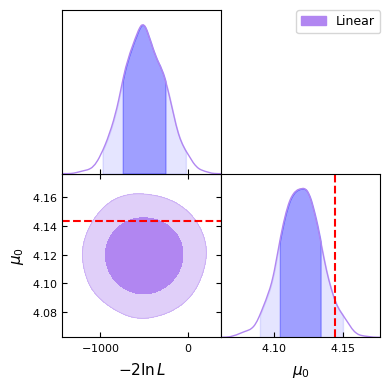

In [31]:
data_fit_full = pd.DataFrame(fits.open("resample_mc_ascaso.fits")[1].data).iloc[:, 0:2].T

data_fit_void = np.array(data_fit_full)
data_fit = []
for item in data_fit_void:
    arr= np.array(item)
    data_fit.append(np.asarray(arr.tolist()))

names = [
    '0',
    '1'
]
labels=[r"-2\ln L" , r"\mu_0", r"\mu_{M1}" ,r"\mu_{Z1}",
        r"\sigma_0", r"\sigma_{M1}", r"\sigma_{Z1}"]
settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 3,
    "smooth_scale_1D": 3,
    "boundary_correction_order": 0,
}
samples3 = MCSamples(samples=data_fit, names=names, labels=labels, settings=settings)

bf=[mcat.get_bestfit_row().dup_array()[i] for i, param in enumerate(names)]

    
samples3.removeBurn(0.3)

# Triangle plot
g2 = plots.get_subplot_plotter()
g2.triangle_plot(
    [samples3],
    filled=True,
    contour_ls="-",
    contour_lws=1,
    fine_bins=1,
    colors=['#b186f1'],
    fontsize=70,
    line_args=[{'lw':1.2,'ls':'-', 'color':'#b186f1'}],
        legend_labels=["Linear", ],
)

for i, param in enumerate(names):
    density = samples3.get1DDensity(param)
    x = density.x
    y = density.P
    lower1sigma = density.getLimits(0.68)[0]
    upper1sigma = density.getLimits(0.68)[1]
    lower2sigma = density.getLimits(0.95)[0]
    upper2sigma = density.getLimits(0.95)[1]
    g2.subplots[i , i].fill_between(
        x, y, where=((x >= lower1sigma) & (x <= upper1sigma)),
        color='blue', alpha=0.3, label='1σ' if i == 0 else ""
    )

    g2.subplots[i , i].fill_between(
        x, y, where=((x >= lower2sigma) & (x <= upper2sigma)),
        color='blue', alpha=0.1, label='2σ' if i == 0 else ""
    )

    
    

for i, param1 in enumerate(names):
    for j, param2 in enumerate(names):
        if i == j:
            g2.subplots[i, j].axvline(bf[i], color='red', linestyle='--', label='Best Fit')
        elif i > j:
           g2.subplots[i, j].axvline(bf[j], color='red', linestyle='--')
           g2.subplots[i, j].axhline(bf[i], color='red', linestyle='--')


plt.savefig('mc_ascaso_corner_plot.png')
plt.show()

In [32]:
lnM = np.array(dmr.props.lnM_cluster.dup_array())
z = np.array(dmr.props.z_cluster.dup_array())
lnR = np.array(dmr.props.lnR_cluster.dup_array())

lnM_resampled_ascaso = np.array(dmr_resampled_ascaso.props.lnM_cluster.dup_array())
z_resampled_ascaso = np.array(dmr_resampled_ascaso.props.z_cluster.dup_array())
lnR_resampled_ascaso = np.array(dmr_resampled_ascaso.props.lnR_cluster.dup_array())

lnM_resampled_ascaso_nocut = np.array(dmr_resampled_ascaso_nocut.props.lnM_cluster.dup_array())
z_resampled_ascaso_nocut = np.array(dmr_resampled_ascaso_nocut.props.z_cluster.dup_array())
lnR_resampled_ascaso_nocut = np.array(dmr_resampled_ascaso_nocut.props.lnR_cluster.dup_array())

lnM_test = lnM_resampled_ascaso != lnM
z_test = z_resampled_ascaso != z
lnR_test = lnR_resampled_ascaso == lnR

for i in range(len(lnM)):
    if lnM_test[i] or z_test[i] or lnR_test[i]:
        print("original:  lnM = %.5f , z = %.5f , lnR = %.5f" % (lnM[i], z[i], lnR[i]))
        print(
            "resampled: lnM = %.5f , z = %.5f , lnR = %.5f \n "
            % (lnM_resampled_ascaso[i], z_resampled_ascaso[i], lnR_resampled_ascaso[i])
        )

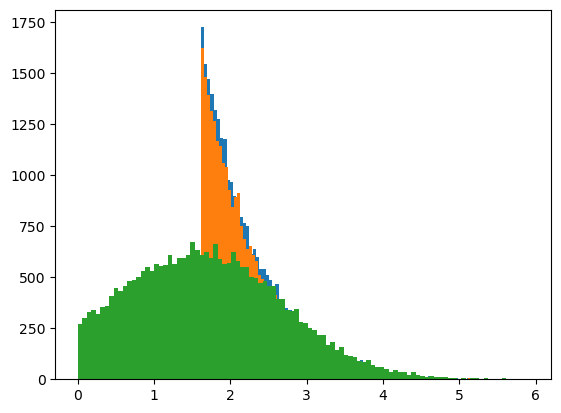

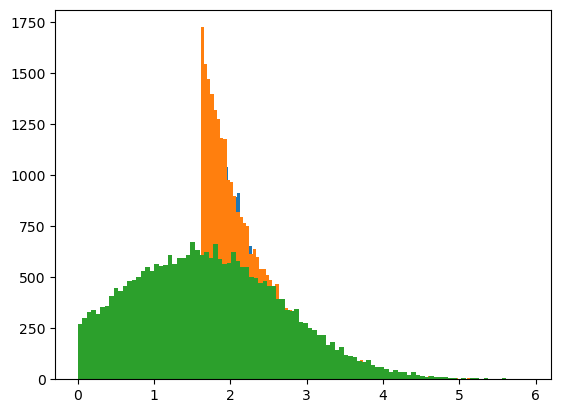

In [33]:
plt.hist(lnR_resampled_ascaso , bins=100)
plt.hist(lnR , bins=100)
plt.hist(lnR_resampled_ascaso_nocut , bins=100)
plt.show()

plt.hist(lnR , bins=100)
plt.hist(lnR_resampled_ascaso , bins=100)
plt.hist(lnR_resampled_ascaso_nocut , bins=100)
plt.show()

In [34]:
hdu = fits.open("resample_extended_data.fits")
table_extended = hdu[1].data
table_extended = Table(table_extended)
table_extended

test_dt = Table([np.exp(table_extended['lnM']), np.exp(table_extended['lnR']), table_extended['z']], names=('mass', 'richness', 'redshift'))
bd = DataB(test_dt, 0.05, 0.05)
fm = ModelFitting(test_dt)

In [35]:
ext_ln1pz, fit_ext ,rm_ext = fm.run_fit('ext_ln1pz')

lnR_mean_ext_ln1pz = fm.get_mean_model(ext_ln1pz,  np.log(test_dt["mass"]),  test_dt["redshift"])
lnR_std_ext_ln1pz = fm.get_std_model(ext_ln1pz,  np.log(test_dt["mass"]),  test_dt["redshift"])

A_ext = lnR_std_ext_ln1pz

D_ext = (1.611 - lnR_mean_ext_ln1pz) / lnR_std_ext_ln1pz 

B_ext = ( 1 / np.sqrt(2 * np.pi) ) * np.exp( -0.5 * ( D_ext ** 2 ) )

C_ext = 1 - 0.5 * ( 1 + erf(D_ext / np.sqrt(2)) )

correction_mean_ext = ( A_ext * B_ext / C_ext )
correction_std_ext = np.sqrt( 1 + ( D_ext * B_ext / C_ext  ) - ( B_ext / C_ext ) ** 2 )

lnR_mean_ext_ln1pz_c = lnR_mean_ext_ln1pz + correction_mean_ext
lnR_std_ext_ln1pz_c  = lnR_std_ext_ln1pz  + correction_std_ext

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  3.19                [FREE]
#   -    muM1[01]:  0.868588963806504   [FREE]
#   -    muZ1[02]: -0.304006137332276   [FREE]
#   -    muM2[03]:  0                   [FREE]
#   -    muZ2[04]:  0                   [FREE]
#   -    muMZ[05]:  0                   [FREE]
#   -  sigma0[06]:  0.33                [FREE]
#   - sigmaM1[07]: -0.0347435585522601  [FREE]
#   - sigmaZ1[08]:  0                   [FREE]
#   - sigmaM2[09]:  0                   [FREE]
#   - sigmaZ2[10]:  0                   [FREE]
#   - sigmaMZ[11]:  0                   [FREE]
#   -      A0[12]:  0                   [FIX

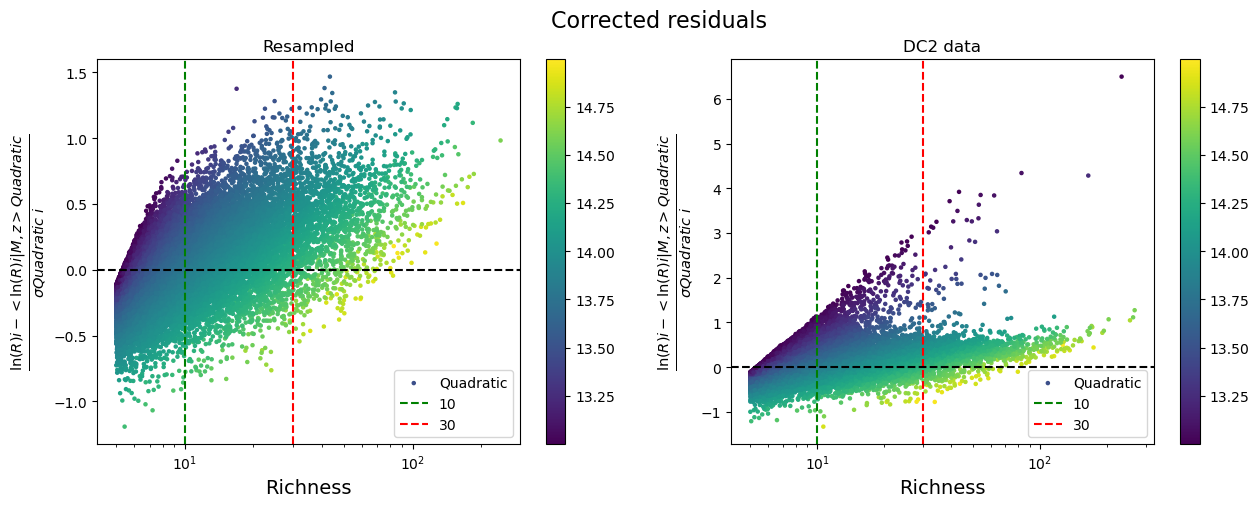

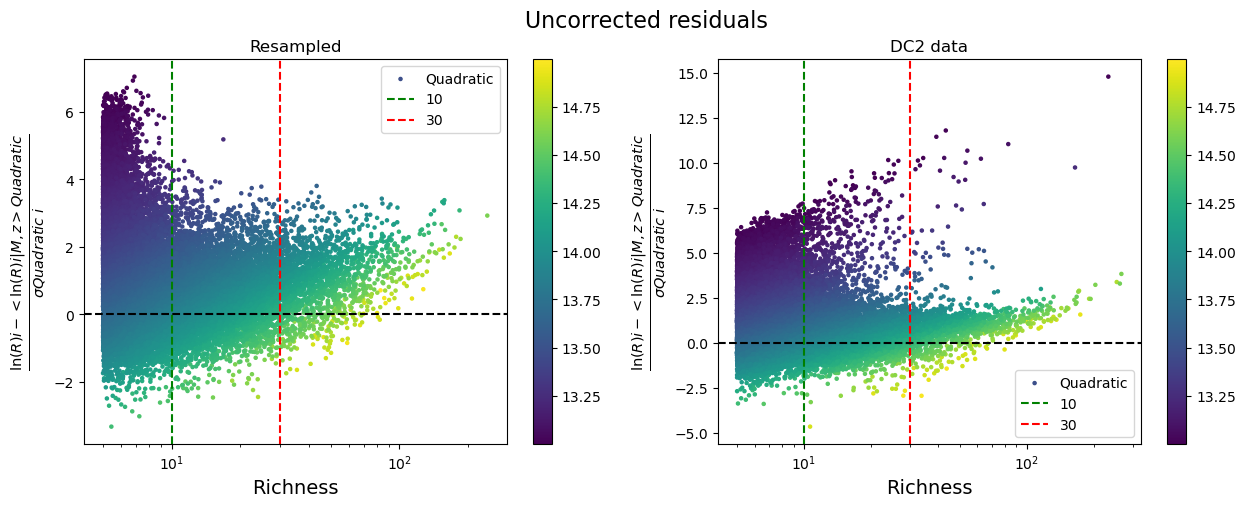

In [89]:
residuals_ext_c = (table_extended['lnR'] - lnR_mean_ext_ln1pz_c) / lnR_std_ext_ln1pz_c
residuals_ext = (table_extended['lnR'] - lnR_mean_ext_ln1pz) / lnR_std_ext_ln1pz

residuals_ext_data_c = (lnR_data- lnR_mean_ext_ln1pz_c) / lnR_std_ext_ln1pz_c
residuals_ext_data = (lnR_data - lnR_mean_ext_ln1pz) / lnR_std_ext_ln1pz

fig = plt.figure(figsize=(15,5))
fig.suptitle('Corrected residuals', fontsize=16)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

a1_scatter = ax1.scatter(np.exp(table_extended['lnR']), residuals_ext_c, c= np.log10(np.exp(table_extended['lnM'])), s=5.0, label = 'Quadratic')


ax1.set_ylabel(r'$\frac{\ln(R){i}  - < \ln(R){i} | M, z >{Quadratic} }{\sigma{Quadratic \ i}}$', fontsize=15)
ax1.axvline(x=10, color='g', ls='--', label='10')
ax1.axvline(x=30, color='r', ls='--', label='30')
ax1.axhline(y=0.0, color='k', ls='--')

ax1.set_title('Resampled')
ax1.set_xscale('log')
ax1.legend()
ax1.set_xlabel('Richness', fontsize=14)


a2_scatter = ax2.scatter(np.exp(lnR_data), residuals_ext_data_c, c= np.log10(np.exp(lnM_data)), s=5.0, label = 'Quadratic')


ax2.set_ylabel(r'$\frac{\ln(R){i}  - < \ln(R){i} | M, z >{Quadratic} }{\sigma{Quadratic \ i}}$', fontsize=15)
ax2.axvline(x=10, color='g', ls='--', label='10')
ax2.axvline(x=30, color='r', ls='--', label='30')
ax2.axhline(y=0.0, color='k', ls='--')

ax2.set_title('DC2 data')
ax2.set_xscale('log')
ax2.legend()
ax2.set_xlabel('Richness', fontsize=14)

fig.colorbar(a1_scatter)
fig.colorbar(a2_scatter)

plt.show()


fig = plt.figure(figsize=(15,5))
fig.suptitle('Uncorrected residuals', fontsize=16)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

a1_scatter =ax1.scatter(np.exp(table_extended['lnR']), residuals_ext, c= np.log10(np.exp(table_extended['lnM'])), s=5.0, label = 'Quadratic')



ax1.set_ylabel(r'$\frac{\ln(R){i}  - < \ln(R){i} | M, z >{Quadratic} }{\sigma{Quadratic \ i}}$', fontsize=15)
ax1.axvline(x=10, color='g', ls='--', label='10')
ax1.axvline(x=30, color='r', ls='--', label='30')
ax1.axhline(y=0.0, color='k', ls='--')

ax1.set_title('Resampled')
ax1.set_xscale('log')
ax1.legend()
ax1.set_xlabel('Richness', fontsize=14)


a2_scatter = ax2.scatter(np.exp(lnR_data), residuals_ext_data, c= np.log10(np.exp(lnM_data)), s=5.0, label = 'Quadratic')

#ax2.colorbar(p2)

ax2.set_title('DC2 data')
ax2.set_ylabel(r'$\frac{\ln(R){i}  - < \ln(R){i} | M, z >{Quadratic} }{\sigma{Quadratic \ i}}$', fontsize=15)
ax2.axvline(x=10, color='g', ls='--', label='10')
ax2.axvline(x=30, color='r', ls='--', label='30')
ax2.axhline(y=0.0, color='k', ls='--')


ax2.set_xscale('log')
ax2.legend()
ax2.set_xlabel('Richness', fontsize=14)
fig.colorbar(a1_scatter)
fig.colorbar(a2_scatter)
plt.show()

In [87]:
test_dt = Table([np.exp(lnM_resampled_ascaso), np.exp(lnR_resampled_ascaso), z_resampled_ascaso], names=('mass', 'richness', 'redshift'))
bd = DataB(test_dt, 0.05, 0.05)
fm = ModelFitting(test_dt)
ascaso, fit_ascaso, rm_ascaso = fm.run_fit('ascaso')

lnR_mean_ascaso = fm.get_mean_model(ascaso,  np.log(test_dt["mass"]),  test_dt["redshift"])
lnR_std_ascaso = fm.get_std_model(ascaso,  np.log(test_dt["mass"]),  test_dt["redshift"])

A = lnR_std_ascaso

D = (1.611 - lnR_mean_ascaso) / lnR_std_ascaso 

B = ( 1 / np.sqrt(2 * np.pi) ) * np.exp( -0.5 * ( D ** 2 ) )

C = 1 - 0.5 * ( 1 + erf(D / np.sqrt(2)) )

correction_mean = ( A * B / C )
correction_std = np.sqrt( 1 + ( D * B / C  ) - ( B / C ) ** 2 )

lnR_mean_ascaso_c = lnR_mean_ascaso + correction_mean
lnR_std_ascaso_c = lnR_std_ascaso * correction_std

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -    mup0[00]:  3.19                [FREE]
#   -    mup1[01]:  0.868588963806504   [FREE]
#   -    mup2[02]: -0.304006137332276   [FREE]
#   - sigmap0[03]:  0.33                [FREE]
#   - sigmap1[04]: -0.0347435585522601  [FREE]
#   - sigmap2[05]:  0                   [FREE]
#   -     cut[06]:  1.6094379124341     [FIXED]
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
.........................................................

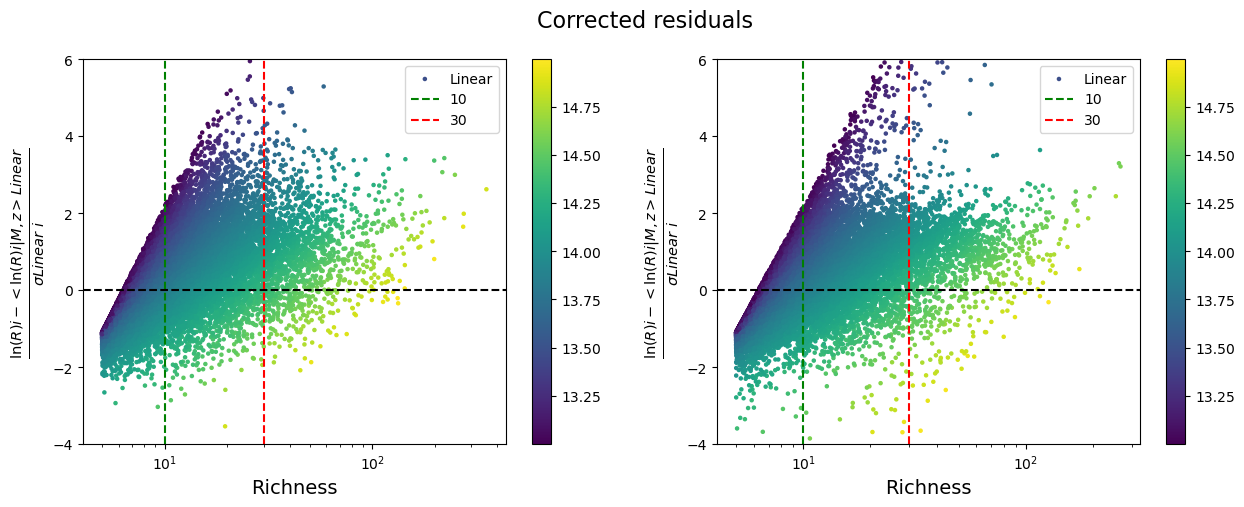

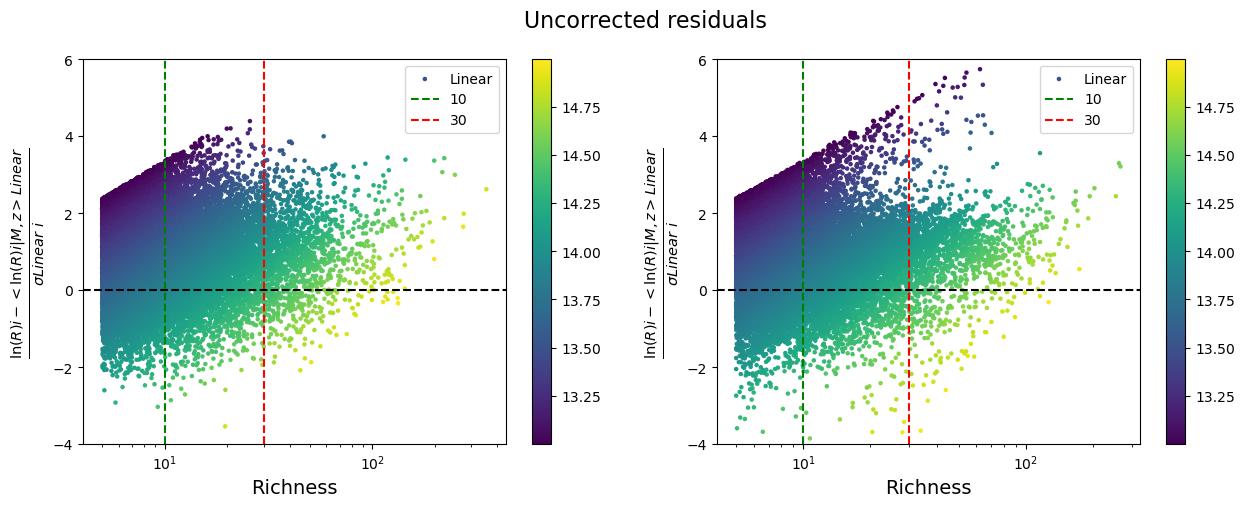

In [90]:
residuals_ascaso_c = (lnR_resampled_ascaso - lnR_mean_ascaso_c) / lnR_std_ascaso_c
residuals_ascaso = (lnR_resampled_ascaso - lnR_mean_ascaso) / lnR_std_ascaso

residuals_ascaso_data_c = (lnR_data- lnR_mean_ascaso_c) / lnR_std_ascaso_c
residuals_ascaso_data = (lnR_data - lnR_mean_ascaso) / lnR_std_ascaso

fig = plt.figure(figsize=(15,5))
fig.suptitle('Corrected residuals', fontsize=16)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

a1_scatter = ax1.scatter(np.exp(lnR_resampled_ascaso), residuals_ascaso_c, c= np.log10(np.exp(lnM_resampled_ascaso)), s=5.0, label = 'Linear')


ax1.set_ylabel(r'$\frac{\ln(R){i}  - < \ln(R){i} | M, z >{Linear} }{\sigma{Linear \ i}}$', fontsize=15)
ax1.set_ylim(-4 , 6)
ax1.axvline(x=10, color='g', ls='--', label='10')
ax1.axvline(x=30, color='r', ls='--', label='30')
ax1.axhline(y=0.0, color='k', ls='--')


ax1.set_xscale('log')
ax1.legend()
ax1.set_xlabel('Richness', fontsize=14)


a2_scatter = ax2.scatter(np.exp(lnR_data), residuals_ascaso_data_c, c= np.log10(np.exp(lnM_data)), s=5.0, label = 'Linear')

ax2.set_ylabel(r'$\frac{\ln(R){i}  - < \ln(R){i} | M, z >{Linear} }{\sigma{Linear \ i}}$', fontsize=15)
ax2.set_ylim(-4 , 6)
ax2.axvline(x=10, color='g', ls='--', label='10')
ax2.axvline(x=30, color='r', ls='--', label='30')
ax2.axhline(y=0.0, color='k', ls='--')


ax2.set_xscale('log')
ax2.legend()
ax2.set_xlabel('Richness', fontsize=14)


fig.colorbar(a1_scatter)
fig.colorbar(a2_scatter)
plt.show()


fig = plt.figure(figsize=(15,5))
fig.suptitle('Uncorrected residuals', fontsize=16)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

a1_scatter = ax1.scatter(np.exp(lnR_resampled_ascaso), residuals_ascaso, c= np.log10(np.exp(lnM_resampled_ascaso)), s=5.0, label = 'Linear')


ax1.set_ylabel(r'$\frac{\ln(R){i}  - < \ln(R){i} | M, z >{Linear} }{\sigma{Linear \ i}}$', fontsize=15)
ax1.set_ylim(-4 , 6)
ax1.axvline(x=10, color='g', ls='--', label='10')
ax1.axvline(x=30, color='r', ls='--', label='30')
ax1.axhline(y=0.0, color='k', ls='--')


ax1.set_xscale('log')
ax1.legend()
ax1.set_xlabel('Richness', fontsize=14)



a2_scatter = ax2.scatter(np.exp(lnR_data), residuals_ascaso_data, c= np.log10(np.exp(lnM_data)), s=5.0, label = 'Linear')

ax2.set_ylabel(r'$\frac{\ln(R){i}  - < \ln(R){i} | M, z >{Linear} }{\sigma{Linear \ i}}$', fontsize=15)
ax2.set_ylim(-4 , 6)
ax2.axvline(x=10, color='g', ls='--', label='10')
ax2.axvline(x=30, color='r', ls='--', label='30')
ax2.axhline(y=0.0, color='k', ls='--')


ax2.set_xscale('log')
ax2.legend()
ax2.set_xlabel('Richness', fontsize=14)

fig.colorbar(a1_scatter)
fig.colorbar(a2_scatter)
plt.show() 